In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side

from operator import add, mul, truediv, sub

from operator import itemgetter

from IPython.display import Latex

from fractions import Fraction

import importlib

from core.arithmetic_manager import ArithManager

from core.util import *

In [20]:

AM = ArithManager()
tokens = AM.tmp('antlrGrammar.g', src)


0 [@0,0:2='2/3',<2>,1:0]
1 [@1,3:3='.',<17>,1:3]
2 [@2,4:4='3',<1>,1:4]
3 [@3,5:4='<EOF>',<-1>,1:5]


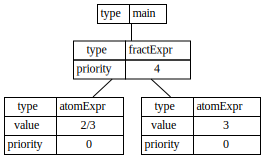

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [148]:
ex1 = '1 + {2 x [(3 + 4 : 2) + 5] x 6} - [ 7 + (1 + 8) : 3 ] x [ 9 : (2 + 1) + 2 ]'
ex2 = '< 2 + 3 > / 4 / < 5 + 6 > / 7'
ex3 = '2 ^ < 3 + 4 ^ 5 : 2 ^ 7 >'
ex4 = '3 + 13 x -<1 + 3>/<2^<1+4> - 6>'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'

expr = '( - ( - - ( ( 43 ) ) ^ 2 x ( - ( 78 ) + - ( 94 ) ) ) x - ( ( 19 - 69 ) ) - - ( ( ( - 100 ^ 2 - ( 36 ) ) ) ) )'


expr = '2 / 3 / 3 '

src = expr

AM = ArithManager()
ptree = AM.ptree('antlrGrammar.g', src)
ast = AM.ptree2ast(ptree)
blocks = AM.blocks(ast)
MEMORY = dict(blocks)

display(ast)

main_block = blocks[-1][1]
child_to_calc = None

current_block = block_id = None

while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]
    
while blocks:
    block_id, current_block = blocks[0]
        
    parent_to_calc = AM.prior(current_block)
    display_latex(AM.latex(main_block, MEMORY))

    parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                if is_next_to_calc(child) else child
                                for child in parent_to_calc.children]
    
    if is_calculable(current_block):
        current_block = current_block.children[0]
        blocks = blocks[1:]
        
    MEMORY[block_id] = current_block

display_latex(AM.latex(main_block, {}))



In [ ]:
2 ** 1/4, pow(2, 1/4)

In [32]:
from core.shunting_yard_parser import ShuntingYardParser
from core.arithmetic_manager import ArithManager
from core.util import *

In [34]:
def ast_eval(ast, show_latex, show_ast):
    AM = ArithManager()
    
    if show_ast: display(ast)
        
    blocks = AM.blocks(ast)
    MEMORY = dict(blocks)
    main_block = blocks[-1][1]
    child_to_calc = None
    current_block = block_id = None

    while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]

    while blocks:
        block_id, current_block = blocks[0]
        parent_to_calc = AM.prior(current_block)
        tex = AM.latex(main_block, MEMORY)
        if show_latex: display_latex(tex)
        
        parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                    if is_next_to_calc(child) else child
                                    for child in parent_to_calc.children]

        if is_calculable(current_block):
            current_block = current_block.children[0]
            blocks = blocks[1:]

        MEMORY[block_id] = current_block

    tex = AM.latex(main_block, {})
    if show_latex: display_latex(tex)
    
    return main_block.children[0].root['value']


def antlr_eval(expr, show_latex=False, show_ast = False):
    AM = ArithManager()
    ast = AM.ptree2ast(AM.ptree('antlrGrammar.g',expr))
    return ast_eval(ast, show_latex, show_ast)


def shunting_eval(expr, show_latex=False, show_ast = False):
    shunting_yard_parser = ShuntingYardParser()

    ast = shunting_yard_parser.parse(expr)
    return ast_eval(ast, show_latex, show_ast)


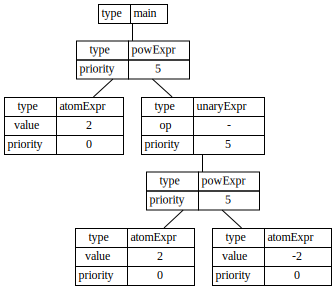

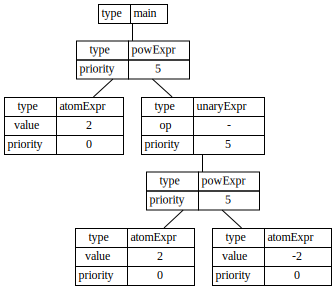

(0.841, 0.841)

In [49]:
expr = '2^-2^-2'
shunting_eval(expr, False, True), antlr_eval(expr, False, True)
#antlr_eval(expr, True)


In [150]:
from core.expression_generator import generate_expression

wrong_expr = []
for _ in range(10):
    exception = False
    expr = generate_expression(2)
    
    try:
        antlr_res = antlr_eval(expr)
    except Exception as e:
        print('** EXCEPTION ANTLR ** ', e)
        exception = True

    try:
        shunting_res = shunting_eval(expr)
        if exception: 
            wrong_expr.append(expr)
            continue
    except Exception as e:
        print('** EXCEPTION SHUNTING ** ', e)
        if not exception: 
            wrong_expr.append(expr)
        continue

    formatted_expr = expr.replace('x', '*').replace(':', '/').replace('^', '**')
    res =  round(eval(formatted_expr), 3)

    if antlr_res != shunting_res or abs(antlr_res - res) > 1:
        print("** WRONG ** ", expr)
        wrong_expr.append(expr)
        
    
    #print(antlr_res, shunting_res, res)
        
if wrong_expr != []:
    print(f'*** WRONG {len(wrong_expr)} ***\n')
    for i, it in enumerate(wrong_expr):
        print(f' $$$ {i} $$$  ', it)
else:
    print("ALL DONE")

** WRONG **  - - 3 / 86 - 64 ^ -2 / - - 13 + 40 / ( 97 ) + - 70 + ( ( ( 95 ) ) x 62 : ( - 73 : 11 - - 51 ) ) / ( - ( 97 + 94 ) ) + ( 6 + 100 - ( ( 49 ) ) : 40 ) - ( - 72 - 56 + 68 / - 14 / 19 ) : ( 53 ) x 75 ^ 2
** WRONG **  - ( - - - 25 / - 33 / 13 ) + ( - ( - 12 / ( ( 12 ) ) : 11 + 46 x 9 ) ) + - - - ( ( 68 ) )
** WRONG **  - - - 94 : ( ( - 14 / 93 ) ) x 80 - - - 56 - 80 : 9 / 76 - 58 ^ -2 - ( - 29 - 57 + ( 31 ) )
** EXCEPTION ANTLR **  both arguments should be Rational instances
** EXCEPTION SHUNTING **  both arguments should be Rational instances
*** WRONG 3 ***

 $$$ 0 $$$   - - 3 / 86 - 64 ^ -2 / - - 13 + 40 / ( 97 ) + - 70 + ( ( ( 95 ) ) x 62 : ( - 73 : 11 - - 51 ) ) / ( - ( 97 + 94 ) ) + ( 6 + 100 - ( ( 49 ) ) : 40 ) - ( - 72 - 56 + 68 / - 14 / 19 ) : ( 53 ) x 75 ^ 2
 $$$ 1 $$$   - ( - - - 25 / - 33 / 13 ) + ( - ( - 12 / ( ( 12 ) ) : 11 + 46 x 9 ) ) + - - - ( ( 68 ) )
 $$$ 2 $$$   - - - 94 : ( ( - 14 / 93 ) ) x 80 - - - 56 - 80 : 9 / 76 - 58 ^ -2 - ( - 29 - 57 + ( 31 ) )


In [164]:
expr = '25 / - 33 / 13'
formatted_expr = expr.replace('x', '*').replace(':', '/').replace('^', '**')

res =  round(eval(formatted_expr), 3)
shunting_eval(expr, True, False), antlr_eval(expr, False, False), res


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-9.84848484848485

In [ ]:
expr = '( 75 - 7 + - 14 x 35 x ( 70 ) - ( 23 x 5 : ( 40 ) ) ) / - - - 97 / - ( 43 ) / - - ( 65 ) ^ 2 x 89 : 34 x 92 : 4 + 95 + 41 / 60 ^ 2 ^ 2 - ( ( 27 - 19 : ( 7 ) - 80 : - 10 ) ) / ( 81 ) - 63 - 20 x ( ( ( ( 41 / 28 / 54 ) x 71 - 48 - 10 x 88 : 46 ^ 2 ) ) ) - ( - ( 64 ) / - - - 9 + 22 - 58 : - 48 ^ 2 ^ 2 ^ 2 ) : - - ( ( ( ( 25 / ( - 89 - 60 + 99 : 56 x 62 ) ^ 2 ) ) ) ^ 2 ) ^ 2'
antlr_res = antlr_eval(expr)

shunting_res = shunting_eval(expr)
antlr_res, shunting_res



In [95]:
75713/2704 * -1/36 * 1/25281 * 2.806 * 515070259.31

-44465.29303204521